In [1]:
library(dplyr)
library(mlbench)
library(catboost)
library(caret)
library(dials)
library(parsnip)
library(workflows)
library(tune)
library(treesnip)
library(Metrics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2

Loading required package: scales

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip


Attaching package: ‘Metrics’


The following objects are masked from ‘package:caret’:

    precision, recall




# Catboost
Catboost can be applied to classification, multi-class classification, ranking and regression. Because the objective here is to minimize the Mean Squared Error (loss function), we initialize a regression problem.

While other algorithms may overfit small datasets, Catboost handles this by implementing ordered boosting, which is a permutation-driven alternative to classic bosting. Ordered boosting modifies the gradient boosting algorithm to avoid target leakage, or prediction shift. Usually, to combat overfitting with gradient boosting, one would slow the learning rate. This however, requires more iterations and increased model train time. Catboost's implementation of ordered boosting addresses this and foregoes the need to add model train time.

Catboost uses oblivious decision trees, which are trees that use the same splitting criterion across the entire level of a tree. An oblivious decision trees can be thought of as a list of conditions, with each condition corresponding to a level in the tree. While constructing a tree, the gradient is approximated in terms of cosine similarity and computed based on all prior trees. This new tree structure is used to boost all prior models. Implementing oblivious decision trees ensures that trees are balanced, less prone to overfitting and also speeds up the prediction generating process.

Catboost also allows you to write your own loss function, analyze feature importances, visualize train statistics and can be integrated with Tensorflow to create a neural network that extracts features using gradient boosting.

## import data

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

## split to test and train

In [4]:
# Split out validation dataset
# create a list of 80% of the rows in the original dataset we can use for training
set.seed(1)
validation_index <- createDataPartition(ml_data$avg_perc_change, p=0.80, list=FALSE)
# select 20% of the data for validation
testing <- ml_data[-validation_index,]
# use the remaining 80% of data to training and testing the models
training <- ml_data[validation_index,]

In [5]:
# function to scale X
normalize <- function(x) {
    return((x - min(x))/(max(x) - min(x)))
}

In [6]:
y_train <- unlist(training[c('avg_perc_change')])
X_train <- data.frame(lapply(training[, 2:21], normalize))

y_test <- unlist(testing[c('avg_perc_change')])
X_test <- data.frame(lapply(testing[, 2:21], normalize))

## convert to catboost specified formt

In [7]:
train_pool <- catboost.load_pool(data = X_train, label = y_train)
test_pool <- catboost.load_pool(data = X_test, label = y_test)

## train the benchmark model

In [8]:
default_model <- catboost.train(learn_pool = train_pool, test_pool = test_pool)

Training catboost with default parameters! See help(catboost.train).



Learning rate set to 0.045615
0:	learn: 0.1682531	test: 0.1582785	best: 0.1582785 (0)	total: 56.6ms	remaining: 56.5s
1:	learn: 0.1671969	test: 0.1581666	best: 0.1581666 (1)	total: 63.1ms	remaining: 31.5s
2:	learn: 0.1662340	test: 0.1579225	best: 0.1579225 (2)	total: 69.3ms	remaining: 23s
3:	learn: 0.1653364	test: 0.1575833	best: 0.1575833 (3)	total: 73.7ms	remaining: 18.3s
4:	learn: 0.1644873	test: 0.1574800	best: 0.1574800 (4)	total: 81.8ms	remaining: 16.3s
5:	learn: 0.1635193	test: 0.1569109	best: 0.1569109 (5)	total: 85.9ms	remaining: 14.2s
6:	learn: 0.1626311	test: 0.1564471	best: 0.1564471 (6)	total: 90.1ms	remaining: 12.8s
7:	learn: 0.1618090	test: 0.1562286	best: 0.1562286 (7)	total: 93.5ms	remaining: 11.6s
8:	learn: 0.1610437	test: 0.1562457	best: 0.1562286 (7)	total: 97.7ms	remaining: 10.8s
9:	learn: 0.1603283	test: 0.1561922	best: 0.1561922 (9)	total: 105ms	remaining: 10.3s
10:	learn: 0.1593825	test: 0.1558452	best: 0.1558452 (10)	total: 108ms	remaining: 9.73s
11:	learn: 0.15

In [9]:
#predict
y_pred=catboost.predict(default_model, test_pool)
# scaled and best model
postResample(y_pred,testing$avg_perc_change)

RMSE   Rsquared        MAE 
0.15272145 0.08228814 0.11002858

## tune the model with grid search of hyperparameters

In [10]:
# make cross-val folds, v = 5 indicates data is randomly split to 5 chunks
cv_folds <- training %>% rsample::vfold_cv(v = 5)

In [11]:
catboost_model <- parsnip::boost_tree( # model specification for CatBoost
    mode = "regression",
    trees = 1000,
    min_n = tune(),
    learn_rate = tune(),
    tree_depth = tune()
) %>% set_engine("catboost", loss_function = "RMSE") # specify CatBoost engine

In [12]:
# grid specification using dials package to automate min/max values of parameters
catboost_params <- dials::parameters(
    min_n(), # min data in leaf
    tree_depth(range = c(4,10)), # depth
    # In most cases, the optimal depth ranges from 4 to 10. 
    # Values in the range from 6 to 10 are recommended. 
    learn_rate() # learning rate
)

catboost_grid <- dials::grid_max_entropy(
    catboost_params,
    size = 20 # set this to a higher number to get better results
    # I don't want to run this all night, so I set it to 30
)
# output grid results
head(catboost_grid)

min_n,tree_depth,learn_rate
<int>,<int>,<dbl>
20,4,3.210696e-05
25,4,6.187784e-09
38,7,1.228651e-08
26,7,6.370610e-08
7,5,5.586267e-10
5,10,6.762212e-10


In [13]:
cbst_wf <- workflows::workflow() %>% add_model(catboost_model) %>% add_formula(avg_perc_change ~ .)

In [14]:
cbst_tuned <- tune::tune_grid(
    object = cbst_wf, 
    resamples = cv_folds, 
    grid = catboost_grid,
    control = tune::control_grid(verbose = FALSE) 
    # set this to TRUE to see in which step of
    # the process you are in
)

In [15]:
cbst_tuned %>% tune::show_best(metric = "rmse", n = 5)

min_n,tree_depth,learn_rate,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,9,0.0154363890,rmse,standard,0.1622222,5,0.004093567,Preprocessor1_Model19
4,4,0.0044865211,rmse,standard,0.1625321,5,0.003873723,Preprocessor1_Model13
22,7,0.0473533479,rmse,standard,0.1649404,5,0.004489105,Preprocessor1_Model15
36,7,0.0006711427,rmse,standard,0.1671814,5,0.003820462,Preprocessor1_Model17
4,8,0.0004273721,rmse,standard,0.1678074,5,0.003813686,Preprocessor1_Model08


In [16]:
cbst_best_params <- cbst_tuned %>% tune::select_best("rmse")

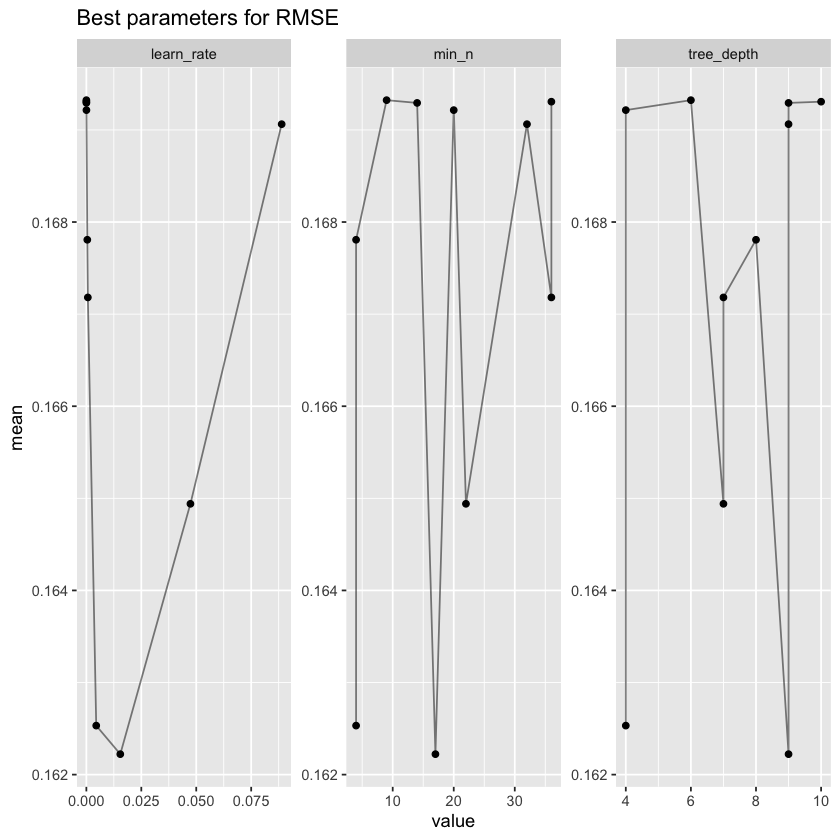

In [17]:
cbst_tuned %>% 
tune::show_best(metric = "rmse",n = 10) %>% 
tidyr::pivot_longer(min_n:learn_rate, names_to="variable",values_to="value" ) %>%
ggplot(aes(value,mean)) + geom_line(alpha=1/2) + geom_point() + facet_wrap(~variable,scales = "free") + ggtitle("Best parameters for RMSE")

# hyperparameters
**iterations** - accepts an integer that specifies the number of trees to train. Default is 1000.<br>
**learning_rate** - specifies the learning rate during the training process. Default is 0.03. <br>
**l2_leaf_reg** - accepts float specifying coefficient of L2 regularization of a loss function. Default value is 3.
**bootstrap_type** - accepts string specifying bootstrap type. Below is a list of possible values. <br>
 - Bayesian
 - Bernoulli
 - MVS
 - Poisson - Only works when training on GPU

**class_names** - accepts a list of string specifying class names for classification tasks.<br>
**classes_count** - accepts integer specifying the number of classes in target for multi-class classification problem.<br>
**depth/max_depth** - accepts integer specifying maximum allowed tree depth in an ensemble. Default is 6. <br>
**min_data_in_leaf** - accepts integer specifying a minimum number of training samples per leaf of a tree. Default is 1. <br>
**max_leaves** - accepts integer specifying the minimum number of leaves in a tree. Default is 31. <br>
**leaf_estimation_method** - accepts the string specifying method used to calculate values in leaves. Below is a list of possible options.
 - Newton
 - Gradient
 - Exact
 <br>
 
 
**monotone_constraints** - accepts list of integers of length n_features. Each entry in the list has a value of either 1,0 or -1, which specify increasing, none, or decreasing monotone relation of a feature with the target. <br>
**early_stopping_rounds** - accepts an integer, which instructs the algorithm to stop training if the last evaluation set in the list has not improved for the specified number of rounds.

## use best model

In [18]:
final_model <- catboost_model %>% finalize_model(cbst_best_params)

In [19]:
final_model

Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 1000
  min_n = 17
  tree_depth = 9
  learn_rate = 0.0154363889842587

Engine-Specific Arguments:
  loss_function = RMSE

Computational engine: catboost 


In [20]:
trained_final_model <- final_model %>%
# fit the model on all the training data
fit(
formula = y_train ~ .,
data = cbind(X_train, y_train)
)

In [21]:
predictions <- trained_final_model %>% predict(new_data = cbind(X_test, y_test))

In [22]:
residuals <- y_test - predictions
prediction_residual <- data.frame(predictions, residuals)
names(prediction_residual)[2] <- 'residuals'
act_pred_resid <- prediction_residual %>% add_column(actual = y_test)

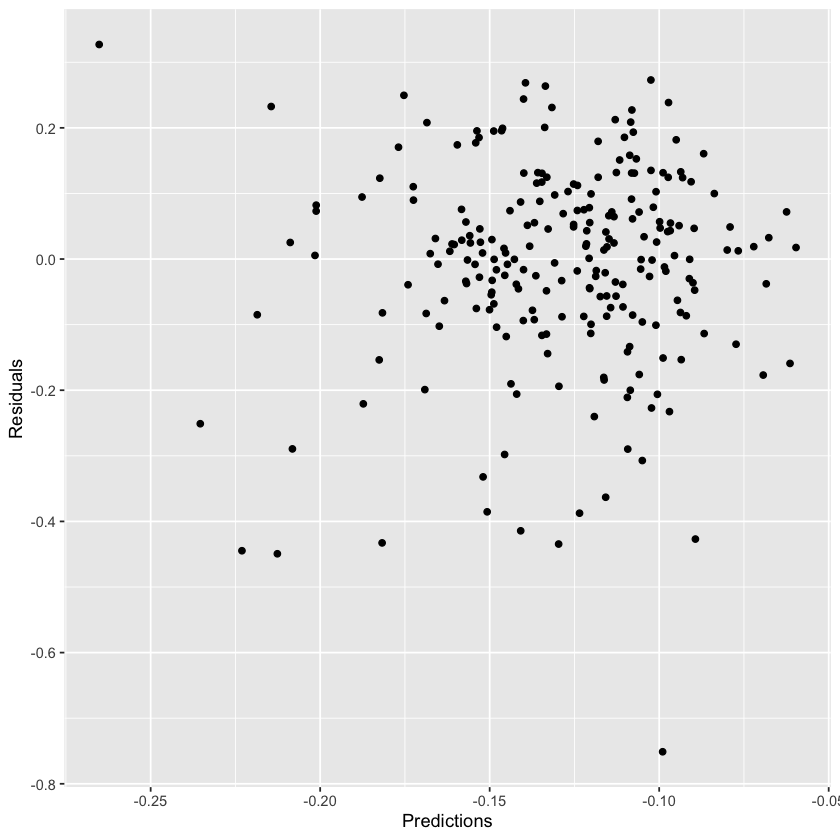

In [23]:
ggplot(prediction_residual, aes(x = .pred, y = residuals)) +
geom_point() +
xlab("Predictions") +
ylab("Residuals")

In [24]:
# rmse
sqrt(mean((act_pred_resid$actual - act_pred_resid$.pred)^2))

[1] 0.1542939

In [25]:
params <- list(iterations = 500, learning_rate = 0.01, depth = 10, loss_function = "RMSE",
    eval_metric = "RMSE", random_seed = 0, od_type = "Iter", metric_period = 50,
    od_wait = 20, use_best_model = TRUE)

In [26]:
model <- catboost.train(learn_pool = train_pool, test_pool = test_pool, params = params)

0:	learn: 0.1690499	test: 0.1585898	best: 0.1585898 (0)	total: 88.9ms	remaining: 44.3s
50:	learn: 0.1535805	test: 0.1564066	best: 0.1564066 (50)	total: 3.87s	remaining: 34s
100:	learn: 0.1410397	test: 0.1551644	best: 0.1551644 (100)	total: 6.76s	remaining: 26.7s
150:	learn: 0.1298685	test: 0.1542304	best: 0.1542304 (150)	total: 9.38s	remaining: 21.7s
200:	learn: 0.1199521	test: 0.1538304	best: 0.1537760 (196)	total: 12.7s	remaining: 19s
250:	learn: 0.1115021	test: 0.1534431	best: 0.1534178 (248)	total: 16.9s	remaining: 16.8s
300:	learn: 0.1042181	test: 0.1531104	best: 0.1530907 (299)	total: 19.4s	remaining: 12.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1530109095
bestIteration = 310

Shrink model to first 311 iterations.


## make predictions

In [27]:
#predict
y_pred=catboost.predict(model,test_pool)

In [28]:
# scaled and best model
postResample(y_pred,testing$avg_perc_change)

RMSE   Rsquared        MAE 
0.15301091 0.08934952 0.11175705

In [29]:
# scaled_data
postResample(y_pred,testing$avg_perc_change)

RMSE   Rsquared        MAE 
0.15301091 0.08934952 0.11175705

In [30]:
# un-scaled data
postResample(y_pred,testing$avg_perc_change)

RMSE   Rsquared        MAE 
0.15301091 0.08934952 0.11175705

## naive_roc_auc_score 

In [31]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [32]:
naive_roc_auc_score(y_test, y_pred)

[1] 0.5902272

# Sources
https://medium.com/ampersand-academy/how-to-create-regression-model-using-catboost-package-in-r-programming-6cce3805a5e1
https://www.r-bloggers.com/2020/08/how-to-use-catboost-with-tidymodels/